In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
import lsst.sims.maf.metricBundles as mmb
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
from lsst.sims.maf.runComparison import RunComparison
import lsst.sims.maf.db as db

/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/runComparison/runComparison.py:23: UserWarning: 
The generateDiffHtml method requires bokeh to be installed
but it is not needed to use the other methods in this class.
Run: pip install bokeh then restart your jupyter notebook kernel.
  'but it is not needed to use the other methods in this class.'+'\n'+


In [3]:
def read_all_metricdata(datadir, metadata):
    # Just read in ALL metrics in the (joint or single) directory, 
    # Note that this will be REALLY SLOW if you give it many directories.
    if metadata is None:
        matchstring = os.path.join(datadir, '*MOOB.npz')
    else:
        matchstring = os.path.join(datadir, f'*{metadata}*MOOB.npz')
    metricfiles = glob.glob(matchstring)
    metricNames = []
    for m in metricfiles:
        mname = os.path.split(m)[-1].replace('_MOOB.npz', '')
        metricNames.append(mname)

    bdict = {}
    for mName, mFile in zip(metricNames, metricfiles):
        bdict[mName] = mmb.createEmptyMoMetricBundle()
        bdict[mName].read(mFile)

    first = bdict[metricNames[0]]
    figroot = f'{first.runName}'
    if metadata is not '.':
        figroot += f'_{metadata}'
    return figroot, bdict

def read_metricdata(datadir, metricName, verbose=True):
    # Just read a specific metric output which matches the pattern of metricName
    matchstring = os.path.join(datadir, f'*{metricName}*MOOB.npz')
    metricfiles = glob.glob(matchstring)
    if len(metricfiles) > 1:
        if verbose:
            print(f'Something is maybe wrong - found {len(metricfiles)} files matching {metricName} in {datadir}')
        return
    if len(metricfiles) == 0:
        if verbose:
            print(f'Something is maybe wrong - found no metricfiles matching {metricName} in {datadir}')
        return
    bundle = mmb.createEmptyMoMetricBundle()
    bundle.read(metricfiles[0])
    return bundle

In [4]:
def norm_df(df, norm_run,
            invert_cols=None, reverse_cols=None, mag_cols=None):
    """
    Normalize values in a dataframe to a given column
    """
    out_df = df.copy()
    if reverse_cols is not None:
        out_df[reverse_cols] = -out_df[reverse_cols]
    if invert_cols is not None:
        out_df[invert_cols] = 1/out_df[invert_cols]
    if mag_cols is not None:
        out_df[mag_cols] = 1 + out_df[mag_cols] - out_df[mag_cols].loc[norm_run]
    else:
        mag_cols = []
    cols = [c for c in df.columns.values if c not in mag_cols]
    out_df[cols] = 1 + (out_df[cols] - out_df[cols].loc[norm_run])/out_df[cols].loc[norm_run]
    return out_df

def plot(d, normed=True, style=None, figsize=(10, 5), run_nicknames=None):
    d.plot(figsize=figsize, style=style)
    plt.legend(loc=(1.01, 0))
    if normed:
        plt.axhline(0.95, alpha=0.3, linestyle=':')
        plt.axhline(1.0, alpha=0.3, linestyle='--')
        plt.axhline(1.05, alpha=0.3, linestyle=':')
    if run_nicknames is not None:
        xnames = run_nicknames
    else:
        xnames = d.index.values
    xi = np.arange(len(xnames))
    plt.xticks(xi, xnames, rotation=90, fontsize='large')
    plt.grid('k:', alpha=0.3)
    plt.tight_layout()

In [5]:
rootDir = '.'
runlist = []
for r in os.listdir(rootDir):
    if '_10yrs' in r:
        if r.startswith('twi_neo') and 'db' in r:
            runlist.append(r.replace('.db', ''))
runlist.append('baseline_nexp2_v1.7_10yrs')

baseline = 'baseline_nexp2_v1.7_10yrs'
twilights = [r for r in runlist if r.startswith('twi_n')]
print(runlist)

families = {}
families['twilight'] = runlist

['twi_neo_pattern2_v1.7_10yrs', 'twi_neo_pattern6_v1.7_10yrs', 'twi_neo_pattern1_v1.7_10yrs', 'twi_neo_pattern5_v1.7_10yrs', 'twi_neo_pattern4_v1.7_10yrs', 'twi_neo_pattern7_v1.7_10yrs', 'twi_neo_pattern3_v1.7_10yrs', 'baseline_nexp2_v1.7_10yrs']


In [6]:
metric_names = {}
short_names = {}
styles = {}
metric_names['sso'] = [#'3 pairs in 15 nights detection loss PHA H=16.0',
               #'3 pairs in 15 nights detection loss PHA H=22.0',
               '3 pairs in 15 nights detection loss NEO H=16.0',
               '3 pairs in 15 nights detection loss NEO H=22.0',
               #'3 pairs in 15 nights detection loss MBA H=16.0',
               #'3 pairs in 15 nights detection loss MBA H=21.0',
               #'3 pairs in 15 nights detection loss Trojan H=14.0',
               #'3 pairs in 15 nights detection loss Trojan H=18.0',
               '3 pairs in 15 nights detection loss TNO H=6.0',
               '3 pairs in 15 nights detection loss TNO H=8.0',]
short_names['sso'] = [#'Completeness PHA H<16.0',
               #'Completeness PHA H<22.0',
               'Completeness NEO H<16.0',
               'Completeness NEO H<22.0',
               #'Completeness MBA H<16.0',
               #'Completeness MBA H<21.0',
               #'Completeness Trojan H<14.0',
               #'Completeness Trojan H<18.0',
               'Completeness TNO H<6.0',
               'Completeness TNO H<8.0',]
styles['sso'] = ['g-','g--', 'b-', 'b--', 'y-', 'y--', 'c-', 'c--', 'r-', 'r--']

metric_names['Lightcurve Inversion'] = [#'FractionPop Lightcurve Inversion PHA H=16.0',
 #'FractionPop Lightcurve Inversion PHA H=19.0',
 'FractionPop Lightcurve Inversion NEO H=16.0',
 'FractionPop Lightcurve Inversion NEO H=19.0',
 #'FractionPop Lightcurve Inversion MBA H=16.0',
 #'FractionPop Lightcurve Inversion MBA H=18.0',
 #'FractionPop Lightcurve Inversion Trojan H=14.0',
 #'FractionPop Lightcurve Inversion Trojan H=15.0']
 ]
short_names['Lightcurve Inversion'] = [#'Fraction LC Inversion PHA H=16.0',
 #'Fraction LC Inversion PHA H=19.0',
 'Fraction LC Inversion NEO H=16.0',
 'Fraction LC Inversion NEO H=19.0',
 #'Fraction LC Inversion MBA H=16.0',
 #'Fraction LC Inversion MBA H=18.0',
 #'Fraction LC Inversion Trojan H=14.0',
 #'Fraction LC Inversion Trojan H=15.0']
]
    
metric_names['Fraction Pop 3 bands'] = [#'FractionPop 2 of g, r or i, z or y PHA H=16.0',
                      #'FractionPop 2 of g, r or i, z or y PHA H=19.0',
                      'FractionPop 2 of g, r or i, z or y NEO H=16.0',
                      'FractionPop 2 of g, r or i, z or y NEO H=19.0',
                      #'FractionPop 2 of g, r or i, z or y MBA H=16.0',
                      #'FractionPop 2 of g, r or i, z or y MBA H=18.0',
                      #'FractionPop 2 of g, r or i, z or y Trojan H=14.0',
                      #'FractionPop 2 of g, r or i, z or y Trojan H=15.0',
                      'FractionPop 3 filters TNO H=6.0',
                      'FractionPop 3 filters TNO H=7.0',]
short_names['Fraction Pop 3 bands'] = [#'Fraction 3 of g and (r or i) and (z or y) PHA H=16.0',
                          #'Fraction 3 of g and (r or i) and (z or y) PHA H=19.0',
                      'Fraction 3 of g and (r or i) and (z or y) NEO H=16.0',
                      'Fraction 3 of g and (r or i) and (z or y) NEO H=19.0',
                      #'Fraction 3 of g and (r or i) and (z or y) MBA H=16.0',
                      #'Fraction 3 of g and (r or i) and (z or y) MBA H=18.0',
                      #'Fraction 3 of g and (r or i) and (z or y) Trojan H=14.0',
                      #'Fraction 3 of g and (r or i) and (z or y) Trojan H=15.0',
                      'Fraction 3 filters TNO H=6.0',
                      'Fraction 3 filters TNO H=7.0',]


metric_names['Fraction Pop 4 bands'] = [#'FractionPop 4 of grizy PHA H=16.0',
                      #'FractionPop 4 of grizy PHA H=19.0',
                      'FractionPop 4 of grizy NEO H=16.0',
                      'FractionPop 4 of grizy NEO H=19.0',
                      #'FractionPop 4 of grizy MBA H=16.0',
                      #'FractionPop 4 of grizy MBA H=18.0',
                      #'FractionPop 4 of grizy Trojan H=14.0',
                      #'FractionPop 4 of grizy Trojan H=15.0',
                      'FractionPop 4 filters TNO H=6.0',
                      'FractionPop 4 filters TNO H=7.0',]
short_names['Fraction Pop 4 bands'] = [#'Fraction 4 of grizy PHA H=16.0',
                          #'Fraction 4 of grizy PHA H=19.0',
                      'Fraction 4 of grizy NEO H=16.0',
                      'Fraction 4 of grizy NEO H=19.0',
                      #'Fraction 4 of grizy MBA H=16.0',
                      #'Fraction 4 of grizy MBA H=18.0',
                      #'Fraction 4 of grizy Trojan H=14.0',
                      #'Fraction 4 of grizy Trojan H=15.0',
                      'Fraction 4 filters TNO H=6.0',
                      'Fraction 4 filters TNO H=7.0',]


metric_names['Fraction Pop 5 bands'] = [#'FractionPop 5 of grizy PHA H=16.0',
                      #'FractionPop 5 of grizy PHA H=19.0',
                      'FractionPop 5 of grizy NEO H=16.0',
                      'FractionPop 5 of grizy NEO H=19.0',
                      #'FractionPop 5 of grizy MBA H=16.0',
                      #'FractionPop 5 of grizy MBA H=18.0',
                      #'FractionPop 5 of grizy Trojan H=14.0',
                      #'FractionPop 5 of grizy Trojan H=15.0',
                      'FractionPop 5 filters TNO H=6.0',
                      'FractionPop 5 filters TNO H=7.0',]
short_names['Fraction Pop 5 bands'] = [#'Fraction with grizy PHA H=16.0',
                          #'Fraction with grizy PHA H=19.0',
                      'Fraction with grizy NEO H=16.0',
                      'Fraction with grizy NEO H=19.0',
                      #'Fraction with grizy MBA H=16.0',
                      #'Fraction with grizy MBA H=18.0',
                      #'Fraction with grizy Trojan H=14.0',
                      #'Fraction with grizy Trojan H=15.0',
                      'Fraction with 5 filters TNO H=6.0',
                      'Fraction with 5 filters TNO H=7.0',]

metric_names['Fraction Pop 6 bands'] = [#'FractionPop 6 of ugrizy PHA H=16.0',
 #'FractionPop 6 of ugrizy PHA H=19.0',
 'FractionPop 6 of ugrizy NEO H=16.0',
 'FractionPop 6 of ugrizy NEO H=19.0',
 #'FractionPop 6 of ugrizy MBA H=16.0',
 #'FractionPop 6 of ugrizy MBA H=18.0',
 #'FractionPop 6 of ugrizy Trojan H=14.0',
 #'FractionPop 6 of ugrizy Trojan H=15.0',
 'FractionPop 6 filters TNO H=6.0',
 'FractionPop 6 filters TNO H=7.0']
short_names['Fraction Pop 6 bands'] = [#'Fraction with ugrizy PHA H=16.0',
                          #'Fraction with ugrizy PHA H=19.0',
                      'Fraction with ugrizy NEO H=16.0',
                      'Fraction with ugrizy NEO H=19.0',
                      #'Fraction with ugrizy MBA H=16.0',
                      #'Fraction with ugrizy MBA H=18.0',
                      #'Fraction with ugrizy Trojan H=14.0',
                      #'Fraction with ugrizy Trojan H=15.0',
                      'Fraction with 6 filters TNO H=6.0',
                      'Fraction with 6 filters TNO H=7.0',]
styles['ssochar'] = ['g-','g--', 'b-', 'b--', 'y-', 'y--', 'c-', 'c--', 'r-', 'r--']

outDir = 'twilight_neo'

In [7]:
# generate footprint maps and number of visits per night for all + NEO
opsdb = {}
for r in runlist:
    rootdir = '.'
    #if r.startswith('twi'):
    #    dbdir = os.path.join(rootdir, 'twilight_neo')
    #if r.startswith('baseline'):
    #    dbdir = os.path.join(rootdir, 'baseline')
    opsdb[r] = db.OpsimDatabase( r + '.db')

In [8]:
# Calculate some metrics 
outDir='temp'

m = metrics.CountMetric(col='observationStartMJD', metricName='Nvisits')
s = slicers.HealpixSlicer(nside=64)
constraint = 'note like "twilight_n%"'

m2 = metrics.CountMetric(col='observationStartMJD', metricName='NvisitsPerNight')
s2 = slicers.OneDSlicer(sliceColName='night', binsize=1)
summarystats = [metrics.MeanMetric(), metrics.MedianMetric(), metrics.CountMetric(),
                metrics.PercentileMetric(metricName='25th%ile', percentile=25),
                metrics.PercentileMetric(metricName='75th%ile', percentile=75)]

bundles = {}
for r in runlist:
    bundles[r] = {}
    bundles[r]['neo'] = mmb.MetricBundle(m, s, constraint, runName=r)
    bundles[r]['all'] = mmb.MetricBundle(m, s, None, runName=r)
    bundles[r]['neopernight'] = mmb.MetricBundle(m2, s2, constraint, runName=r,
                                                  summaryMetrics=summarystats)
    bundles[r]['allpernight'] = mmb.MetricBundle(m2, s2, None, runName=r,
                                                  summaryMetrics=summarystats)
    g = mmb.MetricBundleGroup(bundles[r], opsdb[r], 
                              outDir=outDir, resultsDb=None)
    g.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'fieldRA', 'fieldDec', 'night'].
Found 2530695 visits
Running:  ['all']
Completed metric generation.
Running:  ['allpernight']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint note like "twilight_n%" for columns ['observationStartMJD', 'fieldRA', 'fieldDec', 'night']
Found 591247 visits
Running:  ['neo']
Completed metric generation.
Running:  ['neopernight']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'fieldRA', 'fieldDec', 'night'].


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/slicers/oneDSlicer.py:74: UserWarning: Both binsize and bins have been set; Using binsize 1.000000 only.
  warnings.warn('Both binsize and bins have been set; Using binsize %f only.' %(self.binsize))


Found 2470434 visits
Running:  ['all']
Completed metric generation.
Running:  ['allpernight']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint note like "twilight_n%" for columns ['observationStartMJD', 'fieldRA', 'fieldDec', 'night']
Found 518446 visits
Running:  ['neo']
Completed metric generation.
Running:  ['neopernight']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'fieldRA', 'fieldDec', 'night'].
Found 3013478 visits
Running:  ['all']
Completed metric generation.
Running:  ['allpernight']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint note like "twilight_n%" for columns ['observationStartMJD', 'fieldRA', 'fieldDec', 'night']
Found 1180054 visits
Running:  ['neo'

/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:301: UserWarning: No data matching constraint note like "twilight_n%"
  warnings.warn('No data matching constraint %s' % constraint)
/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:305: UserWarning:  This means skipping metrics ['Nvisits : note like twilight_n% : HealpixSlicer', 'NvisitsPerNight : note like twilight_n% : OneDSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:538: UserWarning: MetricBundle (baseline_nexp2_v1_7_10yrs_NvisitsPerNight_note_like_twilight_n_ONED) has no attribute "metricValues". Either the values have not been calculated or they have been deleted.
  warnings.warn(msg)


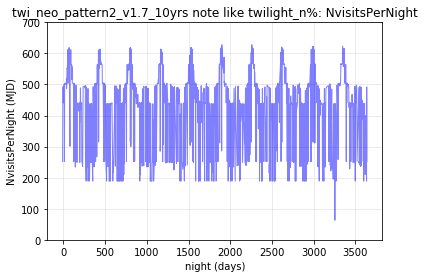

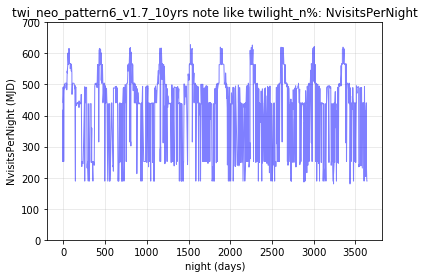

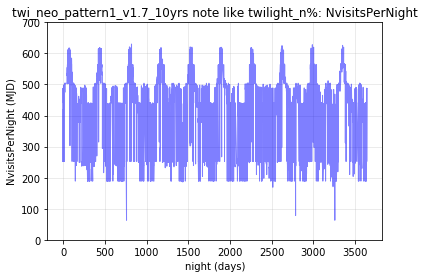

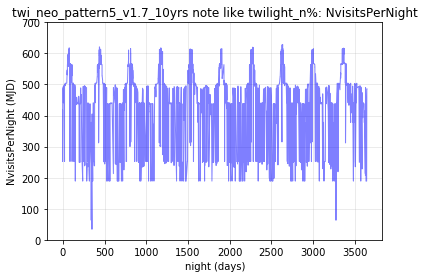

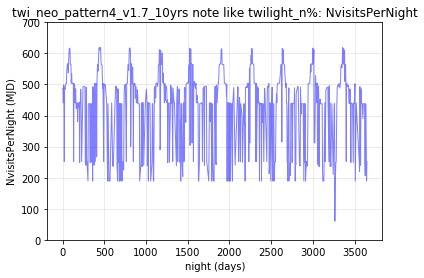

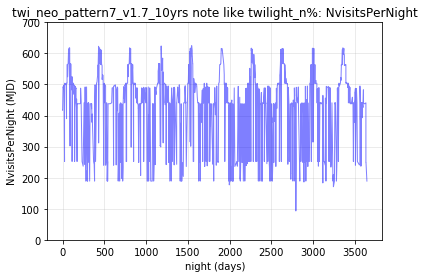

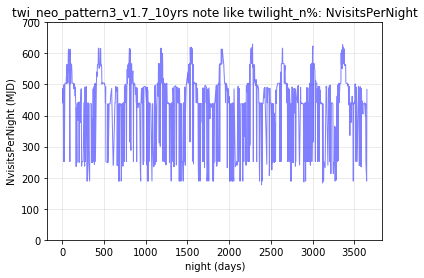

<Figure size 432x288 with 0 Axes>

In [10]:

ph = plots.PlotHandler(outDir=outDir, savefig=True, figformat='png', thumbnail=False)
for r in runlist:
    ph.setMetricBundles([bundles[r]['neopernight']])# bundles[r]['allpernight']])
    ph.plot(plotFunc=plots.OneDBinnedData(), plotDicts={'yMin':0, 'yMax':700})

In [11]:
pd.DataFrame([bundles[r]['neopernight'].summaryValues for r in twilights], 
             index=twilights)

,Mean,Median,Count,25th%ile,75th%ile
twi_neo_pattern2_v1.7_10yrs,431.567153,441.0,1370,384.00,504.0
twi_neo_pattern6_v1.7_10yrs,434.209380,441.0,1194,417.00,504.0
twi_neo_pattern1_v1.7_10yrs,429.110545,441.0,2750,378.00,504.0
twi_neo_pattern5_v1.7_10yrs,430.763043,441.0,1380,378.00,504.0
twi_neo_pattern4_v1.7_10yrs,428.104322,441.0,671,378.00,504.0
twi_neo_pattern7_v1.7_10yrs,430.555921,441.0,912,393.00,504.0
twi_neo_pattern3_v1.7_10yrs,432.307440,441.0,914,405.75,504.0


In [12]:
ph = plots.PlotHandler(outDir=outDir, savefig=True, figformat='png', thumbnail=False)
for r in runlist:
    ph.setMetricBundles([bundles[r]['neo']])
    plotDict = {'colorMin': 0, 'colorMax':500}
    ph.plot(plotFunc=plots.HealpixSkyMap(), plotDicts=plotDict)
    plt.close()
    ph.setMetricBundles([bundles[r]['all']])
    plotDict = {'colorMin': 100, 'colorMax':1200}
    ph.plot(plotFunc=plots.HealpixSkyMap(), plotDicts=plotDict)
    plt.close()

/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:538: UserWarning: MetricBundle (baseline_nexp2_v1_7_10yrs_Nvisits_note_like_twilight_n_HEAL) has no attribute "metricValues". Either the values have not been calculated or they have been deleted.
  warnings.warn(msg)


twi_neo_pattern2_v1.7_10yrs 46
Querying database SummaryAllProps with constraint note like "twilight_n%" and night=46 for columns ['observationStartMJD', 'fieldRA', 'fieldDec']
Found 504 visits
Running:  ['twi_neo_pattern2_v1.7_10yrs']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
twi_neo_pattern6_v1.7_10yrs 50
Querying database SummaryAllProps with constraint note like "twilight_n%" and night=50 for columns ['observationStartMJD', 'fieldRA', 'fieldDec']
Found 504 visits
Running:  ['twi_neo_pattern6_v1.7_10yrs']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
twi_neo_pattern1_v1.7_10yrs 41
Querying database SummaryAllProps with constraint note like "twilight_n%" and night=41 for columns ['observationStartMJD', 'fieldRA', 'fieldDec']
Found 504 visits
Running:  ['twi_neo_pattern1_v1.7_10yrs']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
twi_neo_pattern5

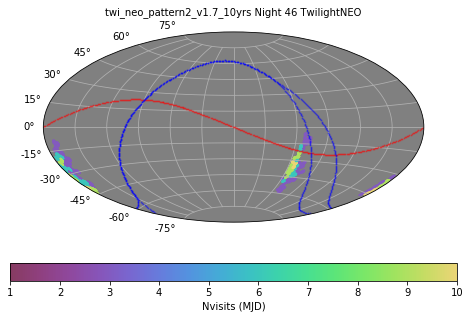

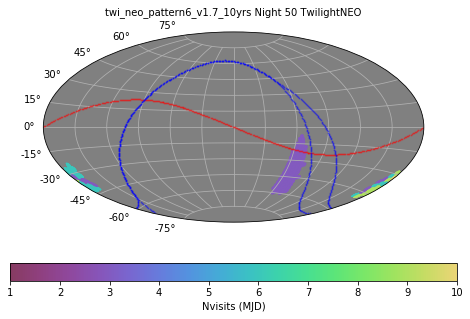

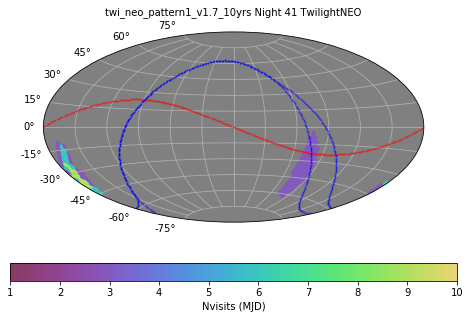

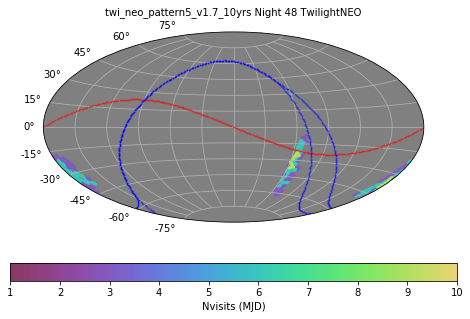

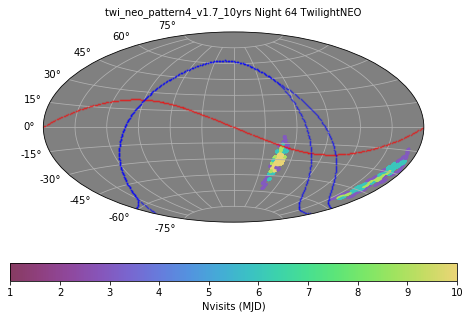

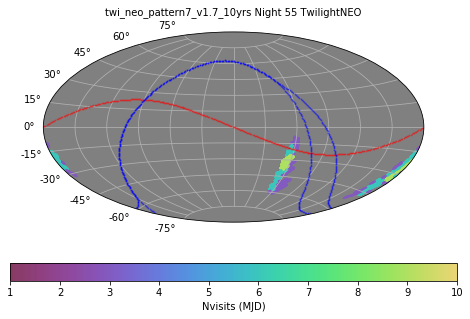

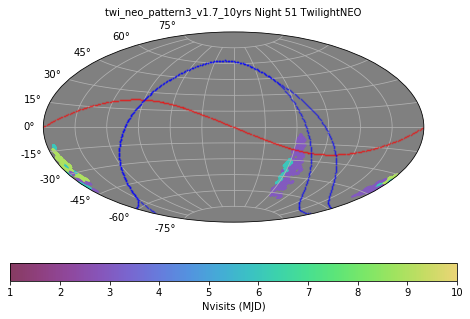

In [13]:
# Plot the distribution of fields for one twilight period with twilight survey 
query = "select count(distinct(observationStartMJD)) as count, night from summaryallprops where note like 'twilight_n%' and night < 100 group by night"
skyplots = {}
for r in twilights:
    res = opsdb[r].query_arbitrary(query)
    night = res['night'][np.where(res['count'] > 500)][5]
    print(r, night)
    # Pull out the ra/decs for these pointings for ONE  of the twilights
    query2 = f'select observationStartMJD, observationStartLST, filter, fieldRA, fieldDec, solarelong from summaryallprops where note like "twilight_n%" and night={night}'
    pointings = opsdb[r].query_arbitrary(query2)
    m = metrics.CountMetric(col='observationStartMJD', metricName='Nvisits')
    s = slicers.UserPointsSlicer(ra=pointings['fieldRA'], dec=pointings['fieldDec'])
    constraint = f'note like "twilight_n%" and night={night}'
    skyplots[r] = mmb.MetricBundle(m, s, constraint, runName=r, plotFuncs=[plots.BaseSkyMap()])
    g = mmb.MetricBundleGroup({r: skyplots[r]}, opsdb[r], outDir=outDir, resultsDb=None)
    g.runAll()
    skyplots[r].setPlotDict({'title': f'{r} Night {night} TwilightNEO', 
                             'raCen':0, 
                             'figsize': (8, 5), 'colorMin': 1, 'colorMax':10})
    skyplots[r].plot(savefig=True, plotHandler=ph)

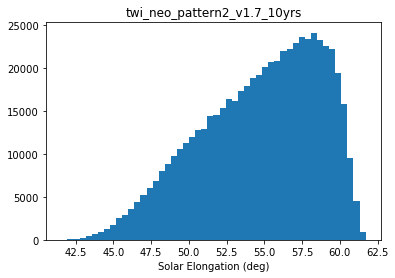

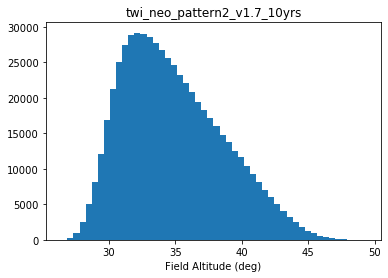

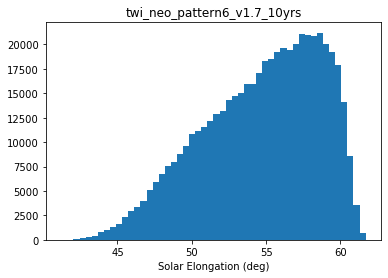

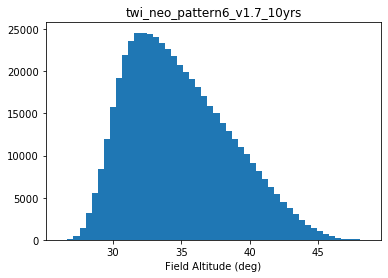

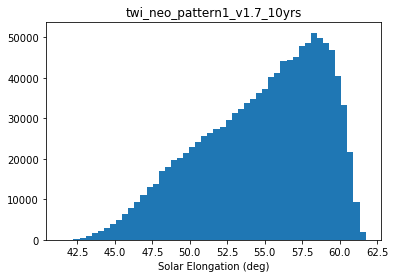

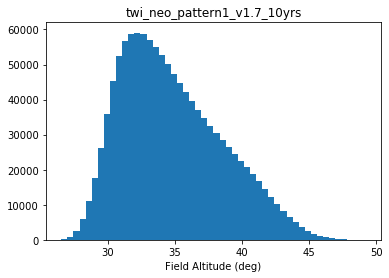

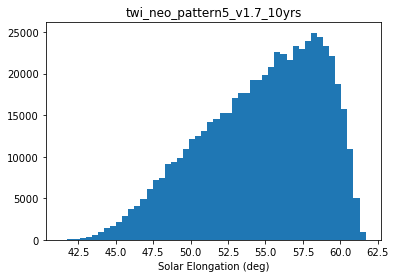

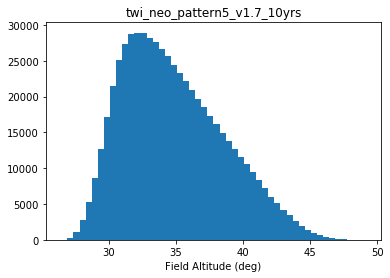

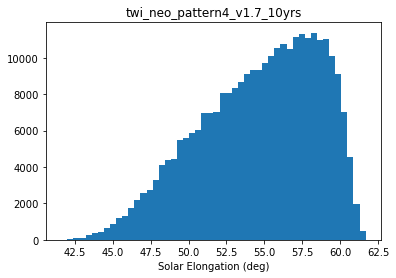

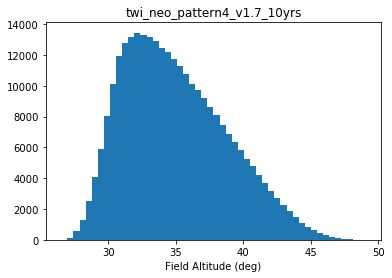

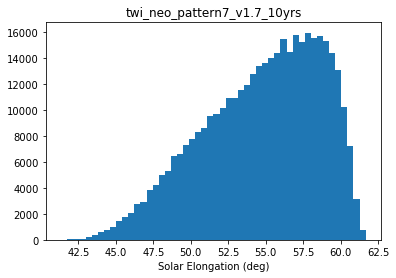

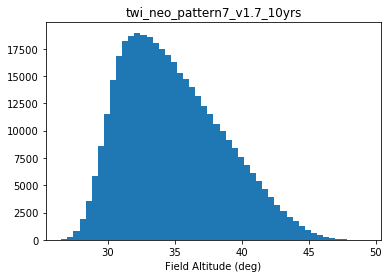

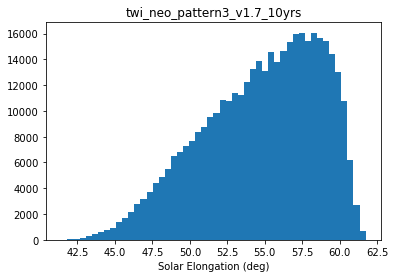

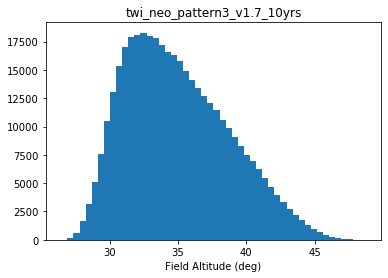

In [14]:
for r in twilights:
    query2 = f'select solarelong, altitude from summaryallprops where note like "twilight_n%"'
    pointings = opsdb[r].query_arbitrary(query2)
    plt.figure()
    plt.hist(pointings['solarElong'], bins=50)
    plt.xlabel('Solar Elongation (deg)')
    plt.title(r)
    plt.savefig(os.path.join(outDir, f'solarElong_{r}.png'), format='png')
    plt.figure()
    plt.hist(pointings['altitude'], bins=50)
    plt.xlabel("Field Altitude (deg)")
    plt.title(r)
    plt.savefig(os.path.join(outDir, f'altitude_{r}.png'), format='png')

In [15]:
nvisits = {}
for r in runlist:
    nvisits[r] = {}
    query = f'select count(distinct(observationStartMJD)) from summaryallprops where proposalId=1 and note not like "twilight_n%"' 
    res = opsdb[r].query_arbitrary(query)
    nvisits[r]['Non-twilight WFD'] = res[0][0]
    query = f'select count(distinct(observationStartMJD)) from summaryallprops where note not like "twilight_n%"'
    res = opsdb[r].query_arbitrary(query)
    nvisits[r]['Non-twilight any'] = res[0][0]
    query = f'select count(distinct(observationStartMJD)) from summaryallprops'
    res = opsdb[r].query_arbitrary(query)
    nvisits[r]['Total Nvisits'] = res[0][0]

In [16]:
for r in runlist:
    nvisits[r]['Non-twilight/Baseline'] = nvisits[r]['Non-twilight any'] / nvisits[baseline]['Non-twilight any']
    nvisits[r]['Non-twilight/Baseline WFD'] = nvisits[r]['Non-twilight WFD'] / nvisits[baseline]['Non-twilight WFD']
pd.DataFrame([nvisits[r] for r in runlist], index=runlist)

,Non-twilight WFD,Non-twilight any,Total Nvisits,Non-twilight/Baseline,Non-twilight/Baseline WFD
twi_neo_pattern2_v1.7_10yrs,25146,1939448,2530695,0.948157,0.981959
twi_neo_pattern6_v1.7_10yrs,25197,1951988,2470434,0.954287,0.983950
twi_neo_pattern1_v1.7_10yrs,24733,1833424,3013478,0.896324,0.965831
twi_neo_pattern5_v1.7_10yrs,25137,1938838,2533291,0.947859,0.981607
twi_neo_pattern4_v1.7_10yrs,25365,1993568,2280826,0.974615,0.990511
twi_neo_pattern7_v1.7_10yrs,25276,1974559,2367226,0.965322,0.987035
twi_neo_pattern3_v1.7_10yrs,25296,1974863,2369992,0.965470,0.987816
baseline_nexp2_v1.7_10yrs,25608,2045493,2045493,1.000000,1.000000


In [17]:
objtypes = ['NEO', 'PHA', 'MBA', 'Trojan', 'TNO']
objcolors = {'NEO': 'r', 'PHA': 'm', 'MBA': 'b', 'Trojan': 'g', 'TNO': 'k'}
objorbits = {'NEO': 'granvik_5k', 'PHA': 'granvik_pha_5k', 'MBA': 'mba_5k', 'Trojan': 'trojan_5k', 'TNO': 'l7_5k'}

In [18]:
# We can pull some of the summary values for these, from the CSV files
# Read the full csv
discovery = pd.read_csv('general_comp/discovery_1.5.csv', index_col=0)
char = pd.read_csv('general_comp/characterization_1.5.csv', index_col=0)
# Pull out just the rows for these runs
discovery = discovery.loc[runlist]
char = char.loc[runlist]

FileNotFoundError: [Errno 2] No such file or directory: 'general_comp/discovery_1.5.csv'

In [ ]:
discovery

In [ ]:
char

In [ ]:
# And we might want to access summary stats from the 'static' evaluations (like metadata, etc)
# You can see what is available by looking at the websites - 
# for example, http://astro-lsst-01.astro.washington.edu:8081/allMetricResults?runId=17

In [ ]:
# First let's look for any trends across these runs
mkey = '3 pairs in 15 nights detection loss'
cols = metrics['sso']
d = discovery[cols]
d.plot(figsize=(15, 5), style=styles['sso'])
plt.legend(loc=(1, 0.05))
xi = np.arange(len(d))
xnames = d.index.values
plt.xticks(xi, xnames, rotation=90, fontsize='large')
plt.grid(True, alpha=0.3)
plt.title('Discovery')

In [ ]:
mkey = '3 pairs in 15 nights detection loss'
cols = metric_names['sso']
D = discovery[cols] / discovery[cols].loc[baseline] 
D.columns = short_names['sso']

xi = np.arange(len(D))
xnames = D.index.values
D.plot(figsize=(13, 5), style=styles['sso'])
plt.legend(loc=(1, 0.05))
plt.grid(True, alpha=0.3, linestyle=':', color='k')
plt.xticks(xi, xnames, rotation=90, fontsize='large')
plt.title('Discovery Variation (%)')
plt.tight_layout()
plt.savefig(os.path.join(outDir, 'discovery_change_twilight.pdf'), format='pdf')

In [ ]:
D

In [ ]:
# characterization

# First let's look for any trends across these runs - normalize each value by the relevant baseline
for k in ['Lightcurve Inversion', 'Fraction Pop 3 bands', 'Fraction Pop 4 bands', 
          'Fraction Pop 5 bands', 'Fraction Pop 6 bands']:
    cols = metric_names[k]
    c = char[cols].loc[families['twilight']] / char[cols].loc[baseline]
    c.columns = short_names[k]
    
    # First let's look for any trends across these runs 
    c.plot(figsize=(15, 5), style=styles['sso'])
    plt.legend(loc=(1, 0.05))
    xi = np.arange(len(c))
    xnames = c.index.values # jointruns
    plt.xticks(xi, xnames, rotation=90, fontsize='large')
    plt.title(f'{k} Variation (%)')
    plt.grid(True, alpha=0.3)
    ylims = plt.ylim()
    plt.grid(True, color='k', linestyle=':', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(outDir, f"{k.replace(' ', '_')}_variation.pdf"), format='pdf')

In [ ]:
C